In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Dataset preparation
batch_size = 16
img_height = 224
img_width = 224
data_dir = '/content/drive/MyDrive/postnatal'

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 2999 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
print(f"Class names: {class_names}")

Class names: ['downSyndorme', 'healty']


In [8]:

# Split dataset into train, val, test
train_size = 0.8
val_size = 0.1
test_size = 0.1

total_count = len(dataset)
train_count = int(total_count * train_size)
val_count = int(total_count * val_size)

train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count).take(val_count)
test_ds = dataset.skip(train_count + val_count)


In [9]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [10]:
# Define Patch Embedding Layer
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, projection_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection = layers.Dense(projection_dim)

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        batch_size = tf.shape(patches)[0]
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return self.projection(patches)

In [11]:
# Define Positional Embedding Layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.pos_embedding = tf.Variable(
            initial_value=tf.random.normal([1, num_patches, projection_dim]),
            trainable=True,
        )

    def call(self, x):
        return x + self.pos_embedding

In [12]:
# Transformer Block
def transformer_block(inputs, num_heads, projection_dim, dropout_rate):
    # Layer normalization
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    # Multi-head attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
    x = layers.Add()([x, inputs])

    # Feed-forward network
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x_ffn = layers.Dense(projection_dim * 4, activation='relu')(x)
    x_ffn = layers.Dropout(dropout_rate)(x_ffn)
    x_ffn = layers.Dense(projection_dim)(x_ffn)
    return layers.Add()([x_ffn, x])

In [13]:
# Vision Transformer Model
def create_vit_model(input_shape, patch_size, projection_dim, num_heads, transformer_layers, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Patch and positional embedding
    patch_embed = PatchEmbedding(patch_size, projection_dim)(inputs)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    pos_embed = PositionalEmbedding(num_patches, projection_dim)(patch_embed)

    # Stacked Transformer Blocks
    x = pos_embed
    for _ in range(transformer_layers):
        x = transformer_block(x, num_heads, projection_dim, dropout_rate=0.1)

    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


In [14]:
# Model Parameters
input_shape = (img_height, img_width, 3)
patch_size = 16
projection_dim = 64
num_heads = 8
transformer_layers = 4
num_classes = len(class_names)

# Create the Vision Transformer model
vit_model = create_vit_model(input_shape, patch_size, projection_dim, num_heads, transformer_layers, num_classes)
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Train the Vision Transformer
epochs = 10
history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - accuracy: 0.4983 - loss: 0.7886 - val_accuracy: 0.5312 - val_loss: 0.6983
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.5535 - loss: 0.7055 - val_accuracy: 0.5417 - val_loss: 0.6962
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 397ms/step - accuracy: 0.5587 - loss: 0.6946 - val_accuracy: 0.5799 - val_loss: 0.6717
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 337ms/step - accuracy: 0.5956 - loss: 0.6737 - val_accuracy: 0.5903 - val_loss: 0.6583
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 340ms/step - accuracy: 0.6270 - loss: 0.6538 - val_accuracy: 0.6319 - val_loss: 0.6423
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 325ms/step - accuracy: 0.6152 - loss: 0.6593 - val_accuracy: 0.6771 - val_loss: 0.6197
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 337ms/step - accuracy: 0.6246 - loss: 0.6525 - val_accuracy: 0.5903 - val_loss: 0.6617
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 320ms/step - accuracy: 0.6199 - loss: 0.6

20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6417 - loss: 0.6407
Test Accuracy: 0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Classification Report:
              precision    recall  f1-score   support

downSyndorme       0.64      0.62      0.63       154
      healty      

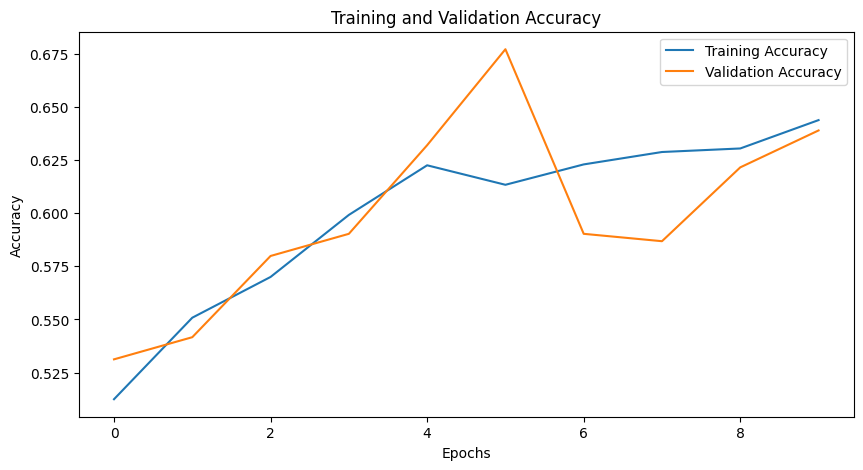

In [16]:
# Evaluate the model
test_loss, test_acc = vit_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions and Classification Report
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = vit_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

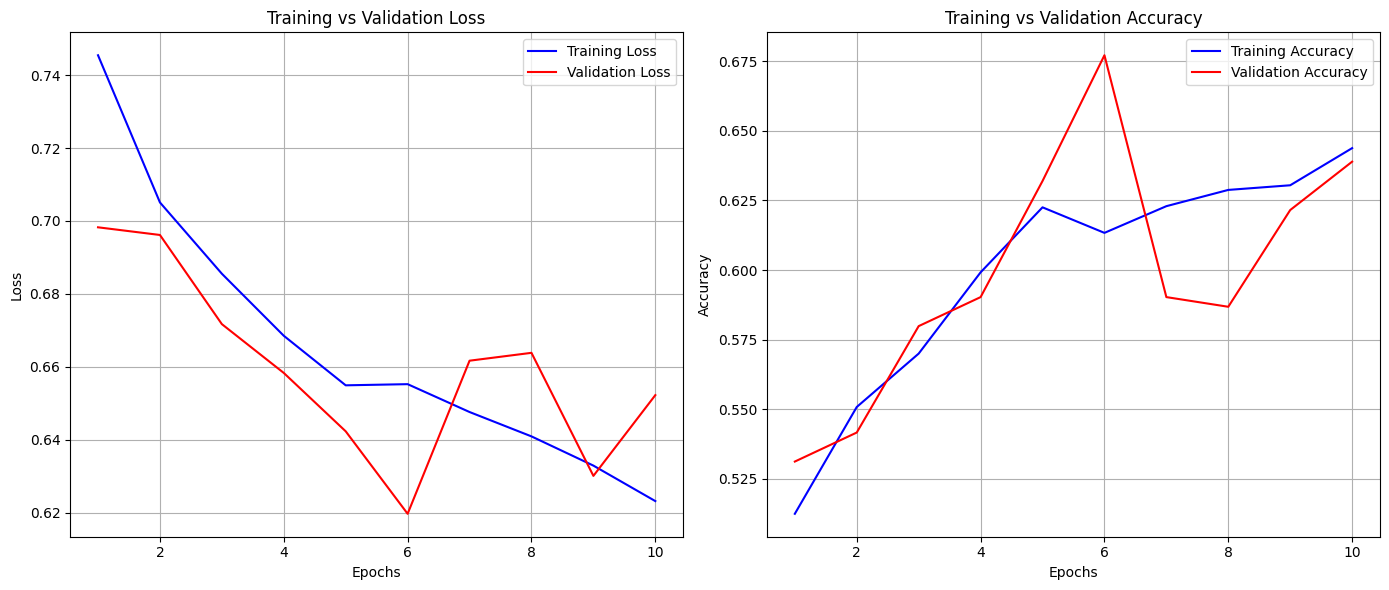

In [22]:
def plot_training_and_validation_curves(history):
    # Extract loss and accuracy data from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # Create subplots for Loss and Accuracy
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot combined Loss and Accuracy curves
plot_training_and_validation_curves(history)
